# NDMI data analysis

Data wrangling for NDMI data.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-01-26 09:56:08 Configured OSMnx 1.1.2
2023-01-26 09:56:08 HTTP response caching is on


## Download data

### NDMI data

In [2]:
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

r = 11

query = f'SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"res\" = {r}'

ndmi = aup.gdf_from_query(query, geometry_col='geometry')
print(ndmi.shape)
ndmi.head(2)

(407141, 8)


,hex_id,geometry,res,ndmi_mean,ndmi_max,ndmi_min,ndmi_diff,city
0,8b49abc9ea84fff,"POLYGON ((-103.60925 20.42353, -103.60908 20.4...",11,0.073175,0.293772,-0.170949,0.464722,Guadalajara
1,8b49abc9eb50fff,"POLYGON ((-103.61445 20.42125, -103.61428 20.4...",11,0.030459,0.367219,-0.105703,0.472922,Guadalajara


### Marginalization

In [3]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

city = 'Guadalajara'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara


In [4]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())

In [5]:
# donwload hexagons with pop data
hex_marg = gpd.GeoDataFrame()
hex_folder = 'hex_bins_marg_2020'
hex_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(1163, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,89.333336,1.282051,7.092198,7.960199,0.0000,0.000000,0.621891,0.000000,1.492537,15.049751,0.373134,8.333333,122.339516,0.955670


## Data analysis

### Univariate analysis

<AxesSubplot: xlabel='ndmi_mean', ylabel='Count'>

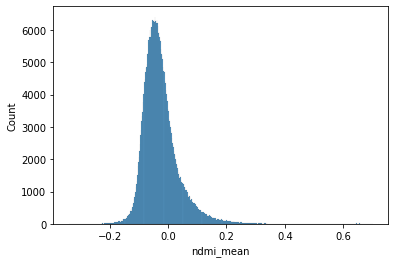

In [6]:
sns.histplot(ndmi['ndmi_mean'])

<AxesSubplot: >

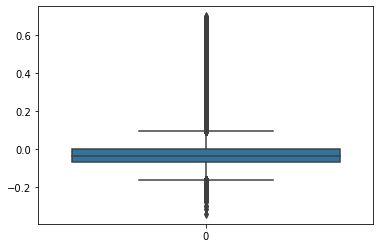

In [11]:
sns.boxplot(data=ndmi['ndmi_mean'])

Mean

In [9]:
ndmi.ndmi_mean.mean()

-0.02465716820871182

Standar deviation

In [10]:
ndmi.ndmi_mean.std()

0.06475208778091499

Median

In [12]:
ndmi.ndmi_mean.median()

-0.03552253714629582

### Bivariate

#### Pretreatment

In [14]:
ndmi_cnt = ndmi[['hex_id','geometry']].copy()
ndmi_cnt = ndmi_cnt.to_crs("EPSG:6372")
ndmi_cnt['geometry'] = ndmi_cnt.centroid
ndmi_cnt = ndmi_cnt.to_crs("EPSG:4326")

In [15]:
ndmi_cnt_marg = ndmi_cnt.overlay(hex_marg)
ndmi_cnt_marg.head(2)

,hex_id,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020,geometry
0,8b49abc9ea84fff,8849abc9ebfffff,14002,273.16855,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744,POINT (-103.60938 20.42379)
1,8b49abc9eb50fff,8849abc9ebfffff,14002,273.16855,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744,POINT (-103.61458 20.42151)


In [16]:
ndmi = ndmi.merge(ndmi_cnt_marg[['hex_id','imn_2020']], on='hex_id')

#### Analysis

<AxesSubplot: xlabel='imn_2020', ylabel='ndmi_mean'>

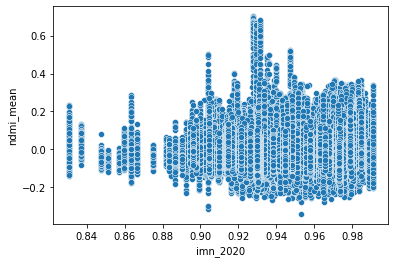

In [17]:
sns.scatterplot(data=ndmi, x="imn_2020", y="ndmi_mean")

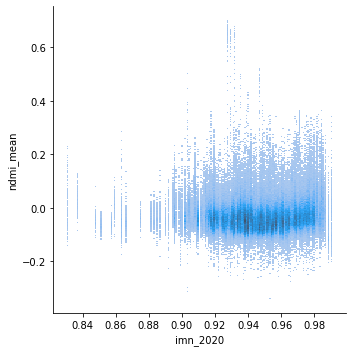

In [18]:
sns.displot(ndmi, x="imn_2020", y="ndmi_mean")

In [19]:
ndmi['Grado_Marg'] = np.nan
ndmi.loc[ndmi.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndmi.loc[(ndmi.imn_2020>=0.946436 )&
             (ndmi.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndmi.loc[(ndmi.imn_2020>=0.926536)&
             (ndmi.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndmi.loc[(ndmi.imn_2020>=0.8999)&
             (ndmi.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndmi.loc[ndmi.imn_2020 < 0.8999, 'Grado_Marg'] = 'Muy alto'

In [20]:
from pandas.api.types import CategoricalDtype


In [21]:
#categorical data
cat_list = ['Muy bajo','Bajo','Medio','Alto', 'Muy alto']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

ndmi['Grado_Marg'] = ndmi['Grado_Marg'].astype(cat_size_order)
ndmi = ndmi.sort_values('Grado_Marg')

Text(0, 0.5, 'NDMI')

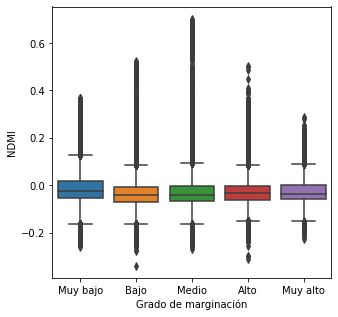

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(x=np.array(ndmi.Grado_Marg) , y=np.array(ndmi.ndmi_mean), ax=ax)

plt.xlabel('Grado de marginación')
plt.ylabel('NDMI')

In [23]:
ndmi.groupby('Grado_Marg').mean()

/tmp/ipykernel_10624/1678047877.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ndmi.groupby('Grado_Marg').mean()


,res,ndmi_mean,ndmi_max,ndmi_min,ndmi_diff,imn_2020
Grado_Marg,,,,,,
Muy bajo,11.0,-0.009369,0.108434,-0.088541,0.196975,0.975612
Bajo,11.0,-0.033525,0.087756,-0.112087,0.199842,0.955853
Medio,11.0,-0.027977,0.133388,-0.126324,0.259712,0.936889
Alto,11.0,-0.025793,0.179374,-0.142155,0.321530,0.917424
Muy alto,11.0,-0.026235,0.207636,-0.160487,0.368123,0.879075


### Spatial autocorrelation

In [28]:
import esda
import pysal

In [24]:
column_analysis = 'ndmi_mean'

In [25]:
import libpysal as lps

wq =  lps.weights.Queen.from_dataframe(ndmi)
wq.transform = 'r'

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [26]:
y = ndmi[column_analysis]
ylag = lps.weights.lag_spatial(wq, y)

In [29]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(ndmi)
wq.transform = 'b'
np.random.seed()
jc = esda.join_counts.Join_Counts(yb, wq)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


Text(0.5, 0, 'BB Counts')

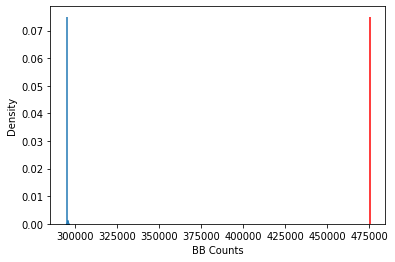

In [30]:
sns.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

In [31]:
mi = esda.moran.Moran(y, wq)

Text(0.5, 0, "Moran's I")

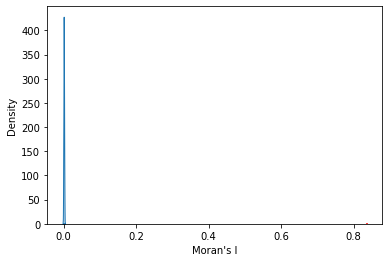

In [32]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [33]:
wq.transform = 'r'
lag_time = lps.weights.lag_spatial(wq, ndmi[column_analysis])

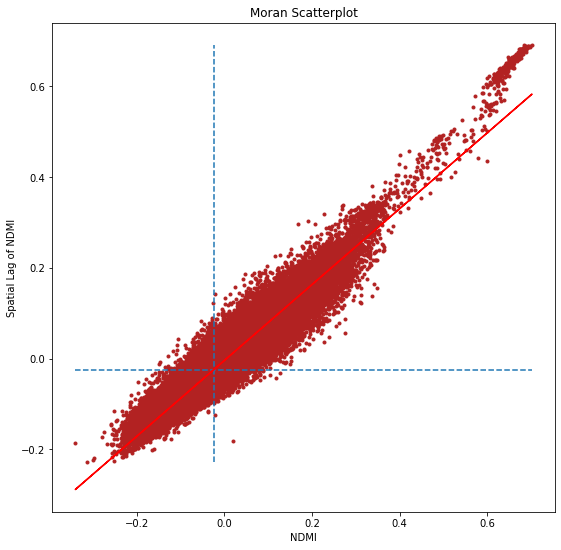

In [35]:
time = ndmi[column_analysis]
b, a = np.polyfit(time, lag_time, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(time, lag_time, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(time.mean(), lag_time.min(), lag_time.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_time.mean(), time.min(), time.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(time, a + b*time, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of NDMI')
plt.xlabel('NDMI')
plt.show()

In [37]:
wq = lps.weights.distance.Kernel.from_dataframe(ndmi[[column_analysis,'geometry']])

li = esda.moran.Moran_Local(y, wq)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [38]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

In [39]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

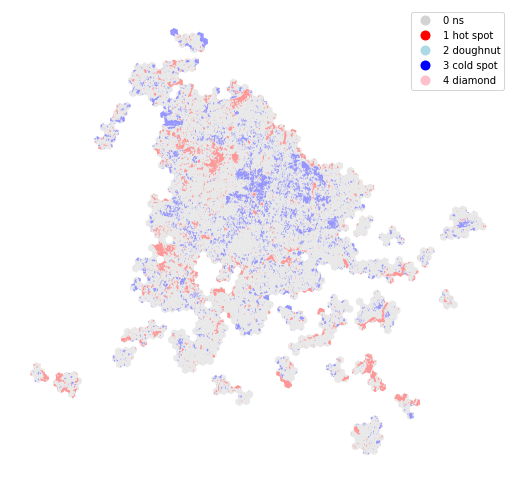

In [40]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
ndmi.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [41]:
ndmi['label'] = np.array(labels)

In [42]:
from splot import esda as esdaplot

In [43]:
lisa = esda.moran.Moran_Local(ndmi[column_analysis], wq)

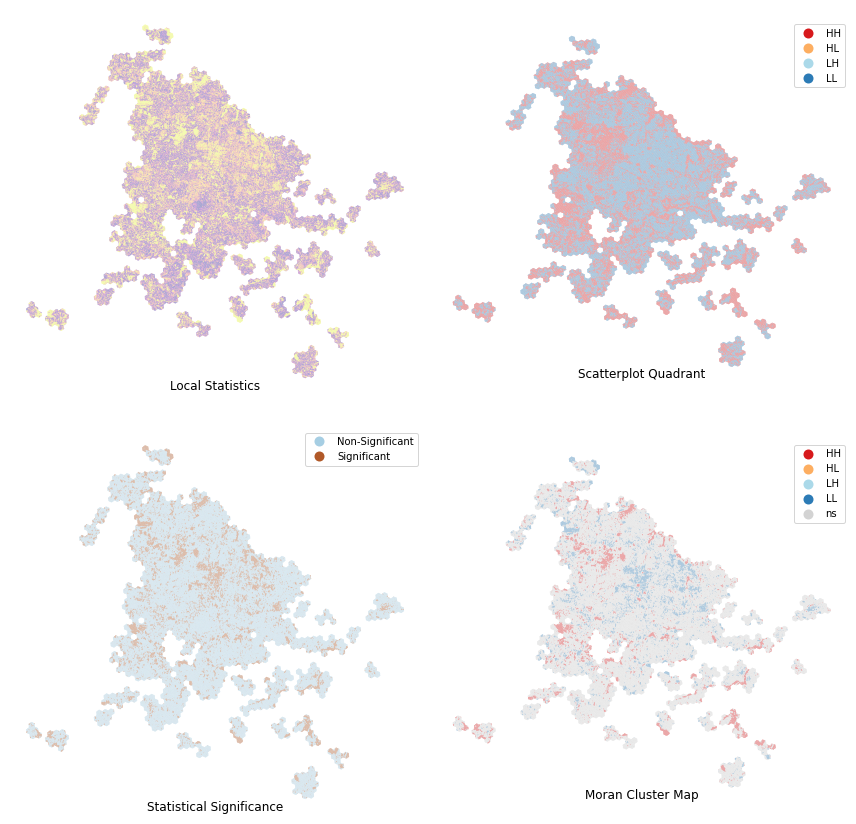

In [44]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
ndmi.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=False,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, ndmi, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=ndmi.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
ndmi.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, ndmi, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()
